Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 36, 138])
 deer horse plane truck


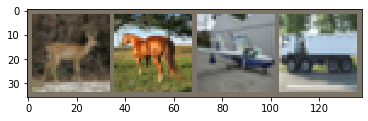

In [1]:
 #===================================================== Import libraries ================================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from models.VGG16_with_flex_v5_BCM import *


# =================================================== Prepare the dataset ===============================================================================

mean_cifar10 = [0.485, 0.456, 0.406]  # Mean and Std value hase been taken from a github implmentation online.
std_cifar10 = [0.229, 0.224, 0.225]
batch_size = 100
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_cifar10,std_cifar10),
])

trainset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=True, download= True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../FlexibleCNNs/data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 10 Classes of the cifar-10

# ========================================== Visualising the dataset ==========================================================================
std= torch.FloatTensor(std_cifar10)
mean = torch.FloatTensor(mean_cifar10)
mean = mean[:,None,None]
std = std[:,None,None]
def imshow(img):
    print(img.size())
    img = img*std + mean     # unnormalize
    
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [2]:
# =============================================================== Model initialisation, Loss function and Optimizer =====================================
model = VGG16()
# Load the pretrained model
state = torch.load('./models/VGG16-flex-v5-block1-model_150_90.pth')
model.load_state_dict(state['model'])
for param in model.parameters():
    param.requires_grad = False


if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001,momentum = 0.9,weight_decay = 0.006)
schedule = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20,gamma = 0.7)

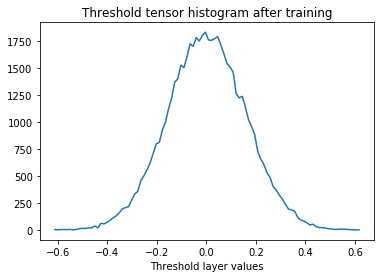

In [3]:
#Plot the initial learned distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        
        thresh_hist = torch.histc(m.threshold1)
        thresh_hist2 = torch.histc(m.threshold1[0,3,:])
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram after training')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

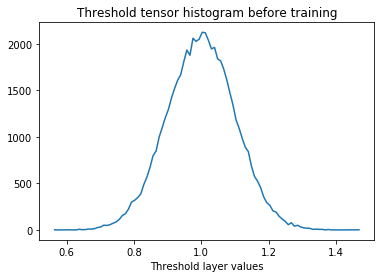

In [4]:
#Reinitilize the threshold values

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        m.threshold1 = torch.nn.Parameter(torch.empty(1, 64, 30, 30).normal_(1,std=0.1).cuda(), requires_grad=True)
        
        thresh_hist = torch.histc(m.threshold1)
        thresh_hist2 = torch.histc(m.threshold1[0,3,:])
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram before training')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [5]:
#Check if requires grad

for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

block1.3.threshold1 tensor([[[[0.9509, 0.7429, 1.0545,  ..., 0.9119, 1.1071, 1.0325],
          [1.0595, 1.0647, 1.1495,  ..., 0.8582, 0.9039, 0.8032],
          [1.0345, 0.7492, 0.8515,  ..., 0.9085, 0.8274, 0.9267],
          ...,
          [0.9367, 0.8600, 0.9369,  ..., 1.0115, 1.0764, 0.9868],
          [0.9125, 0.9229, 1.0229,  ..., 0.8855, 0.9351, 1.0878],
          [1.1062, 0.9582, 0.8607,  ..., 1.2817, 0.9915, 0.9633]],

         [[0.9686, 1.0962, 1.0071,  ..., 1.0552, 0.7060, 1.0086],
          [0.8039, 0.9890, 0.9209,  ..., 1.0691, 1.0245, 0.7498],
          [0.9847, 1.0701, 0.8660,  ..., 1.1024, 0.9098, 0.9504],
          ...,
          [0.9492, 0.8939, 1.1076,  ..., 0.8149, 1.1062, 0.8697],
          [0.9600, 0.9885, 0.9022,  ..., 0.9372, 1.0778, 0.9520],
          [0.9788, 0.9403, 0.9458,  ..., 1.1225, 1.1301, 1.0700]],

         [[1.0692, 1.0343, 0.9741,  ..., 1.0276, 1.0523, 1.0361],
          [1.0322, 0.8888, 0.8391,  ..., 0.9742, 1.0104, 0.8596],
          [1.0430, 1.0

<Figure size 432x288 with 0 Axes>

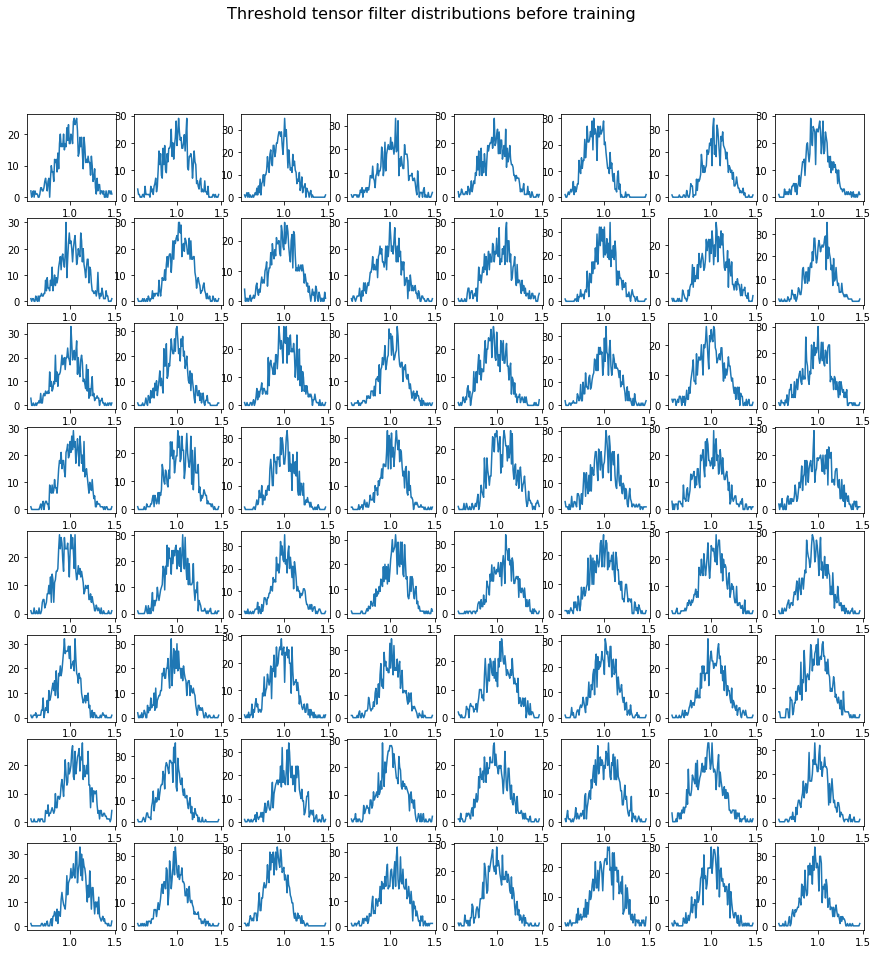

In [6]:
#Plot initial threshold distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
            
        fig2 = plt.figure()
        plt.figure(figsize=(15,15))
        plt.suptitle('Threshold tensor filter distributions before training', fontsize = 16)
        for idx2, filt  in enumerate(m.threshold1[0,:,:,:]):
            thresh_hist = torch.histc(filt)
            plt.subplot(8,8, idx2 + 1)
            plt.plot(xhist, thresh_hist.cpu().detach().numpy())

In [7]:
# ======================== Function to get the test accuracy ===============================================================================
def test():
  correct = 0
  total = 0
  model.train(False)
  with torch.no_grad():
    for i,(images,labels)in enumerate(testloader):
      if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
      outputs = model(Variable(images))
      labels = Variable(labels)
      _,predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted.eq(labels)).sum().item()
    print('Test accuracy: %d %%' % (
  100 * correct / total))
  return 100*(correct/total)

#======================================================= Training =========================================================================
num_epochs = 200  # Train for 150 epochs
start_epoch = 0

total_step = len(trainloader)
train_loss = []  # Store the train_loss per epoch
test_accuracy = [] # Store the test_accuracy per epoch
for epoch in range(start_epoch,num_epochs+1):
  model.train(True)
  epoch_loss  = 0
  i_count = 0
  acc_total = 0
  for i,(images,labels) in enumerate(trainloader):
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    labels = Variable(labels)
    optimizer.zero_grad()
    outputs = model(Variable(images))
    loss = criterion(outputs,labels)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()
    _,predicted = outputs.max(1)
    denom = labels.size(0)
    correct = predicted.eq(labels).sum().item()
    acc = 100*(correct/denom)
    acc_total += acc
    i_count = i_count + 1
    
    #if(i%20 == 0):  # Print the loss per 20 iterations
      #print("Epoch: ",epoch," ","Iteration: ",i," loss: ",loss.item()," Train_iter Accuracy: ",acc)
  schedule.step()
  train_loss.append(epoch_loss)
  print("Epoch: ",epoch," ","Loss: ",epoch_loss," ","Train Accuracy :",acc_total/i_count) # Print train accuracy per epoch
  print('\n')
  test_acc = test()      # Print the test accuracy per epoch
  test_accuracy.append(test_acc)
  
  if(epoch%50 == 0):       # Save the model every 50 epoch
    state = {
        'model': model.state_dict(),
        'acc' : test_acc,
        'optim':optimizer.state_dict(),
        'epoch' : epoch
    }
    path = './models/VGG16-flex-v5-block1-TEST-' + 'model_' + str(int(epoch)) +'_' + str(int(test_acc))+'.pth'
    torch.save(state,path)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#======================================= Testing ===================================================================================================
test_acc = test() # Test error
print(test_acc)

# Per class accuracy
class_correct = list(0. for i in range(10)) # Individual class error
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
#Plot the new learned distribution

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
        
        thresh_hist = torch.histc(m.threshold1)
        thresh_hist2 = torch.histc(m.threshold1[0,3,:])
        start = np.min(m.threshold1.cpu().detach().numpy())
        end = np.max(m.threshold1.cpu().detach().numpy())
        xhist = torch.linspace(start,end,100) # histogram x-axis
        plt.plot(xhist, thresh_hist.cpu().detach().numpy())
        plt.title('Threshold tensor histogram after training')
        plt.xlabel('Count')
        plt.xlabel('Threshold layer values')

In [ ]:
#Plot after training threshold distributions

for idx, m in enumerate(model.block1.modules()):
    if idx == 4:
            
        fig2 = plt.figure()
        plt.figure(figsize=(15,15))
        plt.suptitle('Threshold tensor filter distributions before training', fontsize = 16)
        for idx2, filt  in enumerate(m.threshold1[0,:,:,:]):
            thresh_hist = torch.histc(filt)
            plt.subplot(8,8, idx2 + 1)
            plt.plot(xhist, thresh_hist.cpu().detach().numpy())